In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocess and Load Data

In [4]:
def preprocess_image(image):
    image = image.type(torch.float32)
    image = image / 255.
    return image

In [5]:
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda image: preprocess_image(image)),
    transforms.Resize((128, 128))
])

In [6]:
food101_ds = torchvision.datasets.Food101(root='./data/', download=False, transform=transform)

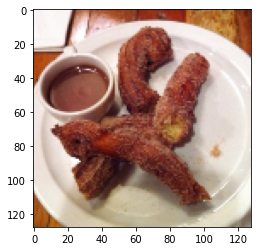

In [7]:
plt.imshow(food101_ds[0][0].permute(1, 2, 0))

In [8]:
food101_dl = torch.utils.data.DataLoader(food101_ds, batch_size=16, shuffle=True)

In [9]:
next_foods = next(iter(food101_dl))[0]

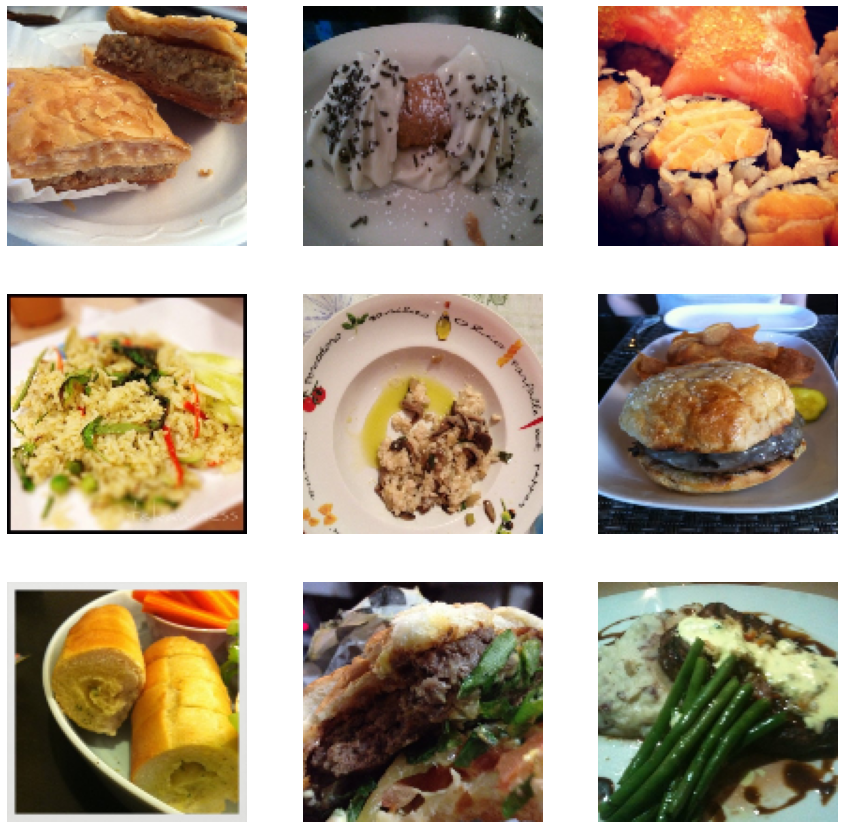

In [10]:
row = 0
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(9):
    if i % 3 == 0 and i != 0:
        row += 1
    ax[row, i % 3].imshow(next_foods[i].permute(1, 2, 0))
    ax[row, i % 3].axis('off')

## Create Supporting Model Objects

In [11]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):  
        super().__init__()
        
        self.res_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, out_channels, 3, padding=1),
        )
        
    def forward(self, x):
        return x + self.res_block(x)
    
class ResidualStack(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, num_residuals):
        super().__init__()
        
        self.num_residuals = num_residuals
        self.res_stack = nn.Sequential()
        
        for _ in range(num_residuals):
            self.res_stack.append(Residual(in_channels, out_channels, hidden_channels))
        
    def forward(self, x):
        return self.res_stack(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 4, 2, padding=1)
        self.conv2 = nn.Conv2d(256, 256, 4, 2, padding=1)
        self.conv3 = nn.Conv2d(256, 64, 1)
        
        self.res_stack = ResidualStack(256, 256, 256, 3)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        y = self.res_stack(x)
        x += y
        y = self.res_stack(x)
        x += y
        y = self.res_stack(x)
        x += y
        
        x = self.conv3(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(64, 256, 1)
        self.conv_transpose1 = nn.ConvTranspose2d(256, 256, 4, 2, padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(256, 3, 4, 2, padding=1)
        
        self.res_stack = ResidualStack(256, 256, 256, 3)
    
    def forward(self, x):  
        x = self.conv1(x)
        
        y = self.res_stack(x)
        x += y
        y = self.res_stack(x)
        x += y
        y = self.res_stack(x)
        x += y
        
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        return x

In [12]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_weight):
        super().__init__()
        
        self._num_embeddings = num_embeddings
        self._embedding_dim = embedding_dim
        self._beta = commitment_weight
        
        self.codebook = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self.codebook.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_flattened = x.view(-1, self._embedding_dim)
        
        euclid_distance = torch.sum(x_flattened ** 2, dim=1, keepdim=True) + \
                          torch.sum(self.codebook.weight ** 2, dim=1) - \
                          2 * torch.matmul(x_flattened, self.codebook.weight.t())
        
        encoding_indices = torch.argmin(euclid_distance, dim=1).unsqueeze(1)
        encodings = torch.zeros((euclid_distance.shape[0], self._num_embeddings), device=x.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        quantized = torch.matmul(encodings, self.codebook.weight).view(x.shape)
        
        e_loss = F.mse_loss(quantized.detach(), x)
        q_loss = F.mse_loss(quantized, x.detach())
        loss = e_loss + q_loss * self._beta
        
        quantized = x + (quantized - x).detach()
        
        avg_probs = torch.mean(encodings, 0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        
        return loss, quantized, perplexity, encodings, encoding_indices
    
    def get_quantized(self, encoding_indices):
        batch, _, row, col = encoding_indices.shape
        encodings = torch.zeros((batch*row*col, self._num_embeddings), device=encoding_indices.device)
        encodings.scatter_(1, encoding_indices.view(-1, 1).long(), 1)
        
        quantized = torch.matmul(encodings, self.codebook.weight).view(batch, row, col, -1)
        return quantized.permute(0, 3, 1, 2).contiguous()

In [13]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_weight):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_weight)
        
    def forward(self, x):
        encoded = self.encoder(x)
        loss, quantized, perplexity, encodings, encoding_indices = self.vq(encoded)
        decoded = self.decoder(quantized)
        return loss, decoded, perplexity
    
    def get_quantized(self, encoding_indices):
        return self.vq.get_quantized(encoding_indices)

In [14]:
def visualize_reconstruction(data, reconstructions):
    row = 0
    fig, ax = plt.subplots(2, 4, figsize=(20, 20))

    for i in range(8):
        if i % 4 == 0 and i != 0:
            row += 1
        if row == 0:
            ax[row, i % 4].imshow(data[i % 4].permute(1, 2, 0).cpu().detach().numpy())
        else:
            ax[row, i % 4].imshow(reconstructions[i % 4].permute(1, 2, 0).cpu().detach().numpy())
        ax[row, i % 4].axis('off')
    plt.show()

## Create Model and Train

In [15]:
torch.cuda.empty_cache() 

In [16]:
vqvae = VQVAE(512, 64, 0.25).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=2e-4)
# vqvae.load_state_dict(torch.load('vqvae_100000.pkl'))
# vqvae.eval()

VQVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (res_stack): ResidualStack(
      (res_stack): Sequential(
        (0): Residual(
          (res_block): Sequential(
            (0): ReLU()
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (1): Residual(
          (res_block): Sequential(
            (0): ReLU()
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (2): Residual(
          (res_block): Sequential(
            (0): ReLU()
      

61000 iterations, recon_error: 0.003, vq_loss: 0.003, loss: 0.006



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


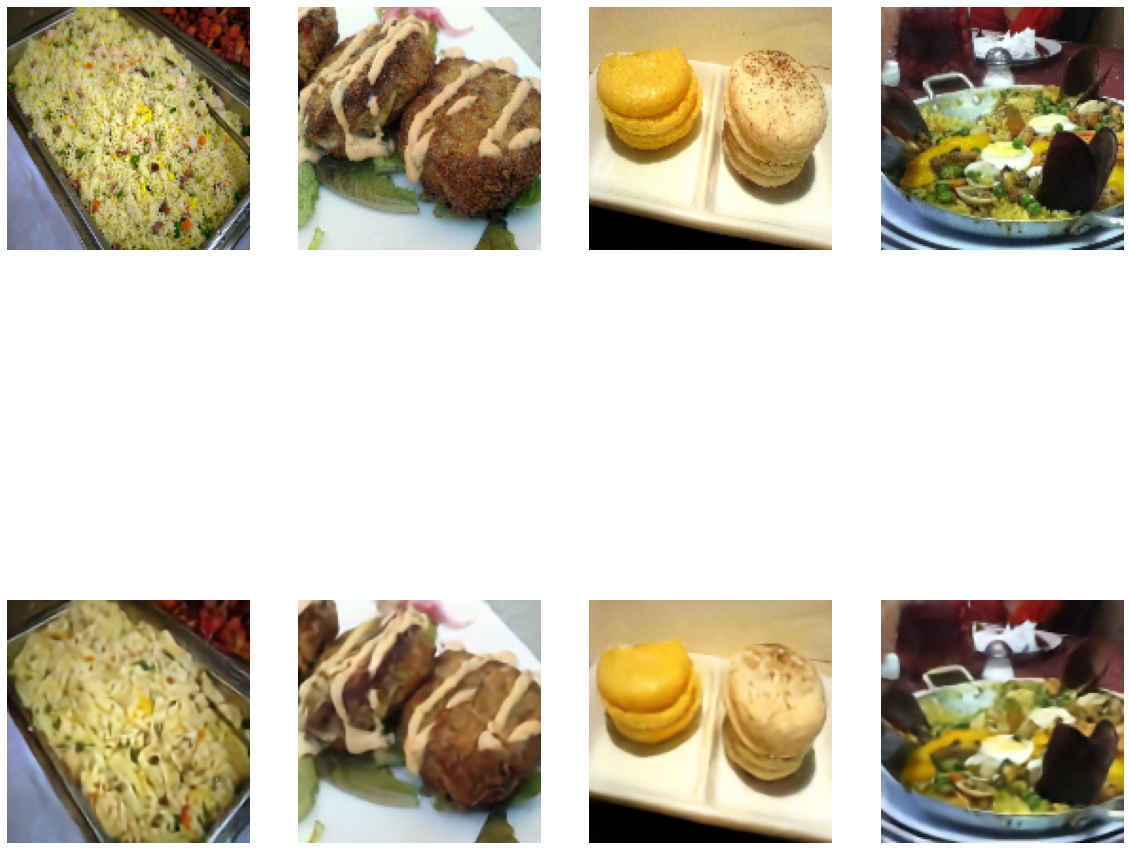


KeyboardInterrupt



In [17]:
train_reconstruction_errors = []
train_vq_loss = []
train_loss = []

for i in range(100_000):
    (data, _) = next(iter(food101_dl))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_reconstruction, perplexity = vqvae(data)
    reconstruction_error = F.mse_loss(data_reconstruction, data)
    loss = reconstruction_error + vq_loss
    loss.backward()

    optimizer.step()

    train_reconstruction_errors.append(reconstruction_error.item())
    train_vq_loss.append(vq_loss.item())
    train_loss.append(loss.item())

    if (i+1) % 1_000 == 0:
        display.clear_output(wait=True)
        print('{:d} iterations, recon_error: {:.3f}, vq_loss: {:.3f}, loss: {:.3f}\r\n'.format(i+1, np.mean(train_reconstruction_errors[-100:]), np.mean(train_vq_loss[-100:]), np.mean(train_loss[-100:])))
        torch.save(vqvae.state_dict(), 'vqvae_100000.pkl')
        
        encoded = vqvae.encoder(data)
        _, quantized, _, _, _ = vqvae.vq(encoded)
        reconstructions = vqvae.decoder(quantized)
        visualize_reconstruction(data, reconstructions)

In [ ]:
# torch.save(vqvae.state_dict(), 'vqvae_100000.pkl')

## Evaluate Model Reconstruction

In [84]:
(data, _) = next(iter(food101_dl))
data = data.to(device)

In [85]:
encoded = vqvae.encoder(data)
loss, quantized, perplexity, encodings, encoding_indices = vqvae.vq(encoded)
reconstructions = vqvae.decoder(quantized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


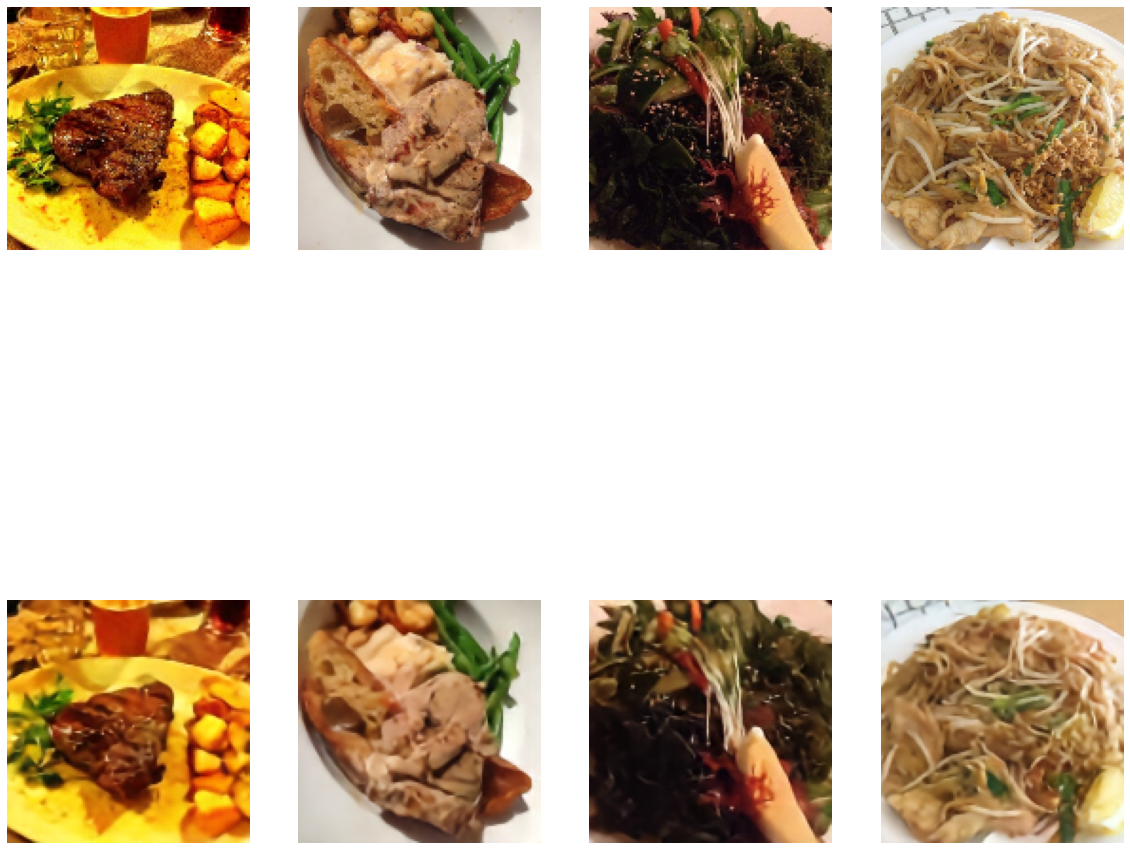

In [86]:
visualize_reconstruction(data, reconstructions)

## Create PixelCNN Supporting Model Objects¶

In [55]:
class PixelConvLayer(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(PixelConvLayer, self).__init__(*args, **kwargs)
        
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        
        _, channels, row, col = self.weight.size()
        self.mask.fill_(1)
        if mask_type =='A':
            self.mask[:,:,row//2,col//2:] = 0
            self.mask[:,:,row//2+1:,:] = 0
        else:
            self.mask[:,:,row//2,col//2+1:] = 0
            self.mask[:,:,row//2+1:,:] = 0
        
    def forward(self, x):        
        self.weight.data*=self.mask
        return super(PixelConvLayer, self).forward(x)
    
    
class PixelResidualBlock(nn.Module):
    def __init__(self, mask_type):
        super().__init__()
        self.mask_type = mask_type
        
        self.conv1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, padding='same')
        self.conv2 = PixelConvLayer(mask_type=mask_type, in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding='same')
        self.relu = nn.ReLU()
        
    def forward(self, x):
        z = self.conv1(x)
        z = self.relu(z)
        z = self.conv2(z)
        z = self.relu(z)
        z = self.conv3(z)
        z = self.relu(z)
        return x + z

In [56]:
class PixelCNN(nn.Module):
    def __init__(self, num_residuals):
        super().__init__()
        
        self.conv1 = PixelConvLayer(mask_type='A', in_channels=1, out_channels=256, kernel_size=7, padding='same')
        self.conv2 = PixelConvLayer(mask_type='B', in_channels=256, out_channels=128, kernel_size=1, padding='same')
        self.conv3 = PixelConvLayer(mask_type='B', in_channels=128, out_channels=512, kernel_size=1, padding='same')
        self.relu = nn.ReLU()
        
        self.res_stack = nn.Sequential()
        for _ in range(num_residuals):
            self.res_stack.append(PixelResidualBlock(mask_type='B'))
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.res_stack(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

## Create PixelCNN and Train

In [57]:
pixelcnn = PixelCNN(10).to(device)
optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=1e-4)
# pixelcnn.load_state_dict(torch.load('pixelcnn_100000.pkl'))
# pixelcnn.eval()

ce = nn.CrossEntropyLoss()

In [58]:
ce_loss = []

for i in range(100_000):
    (data, _) = next(iter(food101_dl))
    data = data.to(device)
    
    encoded = vqvae.encoder(data)
    _, _, _, _, encoding_indices = vqvae.vq(encoded)
    reshaped_enc_ind = encoding_indices.view(-1, 1, 32, 32).to(device)
    
    optimizer.zero_grad()

    logits = pixelcnn(reshaped_enc_ind.float())
    loss = ce(logits.unsqueeze(2), reshaped_enc_ind.long())
    loss.backward()

    optimizer.step()
    
    ce_loss.append(loss.item())
    
    if (i+1) % 1_000 == 0:        
        print(f'{i+1} Loss: ', np.mean(ce_loss[-100:]))
        torch.save(pixelcnn.state_dict(), 'pixelcnn_100000.pkl')

1000 Loss:  5.946614155769348
2000 Loss:  5.821249575614929
3000 Loss:  5.757360777854919
4000 Loss:  5.704476842880249
5000 Loss:  5.6780540657043455
6000 Loss:  5.656024341583252
7000 Loss:  5.63327109336853
8000 Loss:  5.611783862113953
9000 Loss:  5.571849546432495
10000 Loss:  5.553713159561157
11000 Loss:  5.517516088485718
12000 Loss:  5.493522419929504
13000 Loss:  5.48794801235199
14000 Loss:  5.4315049362182615
15000 Loss:  5.429647483825684
16000 Loss:  5.400680756568908
17000 Loss:  5.369995012283325
18000 Loss:  5.3405828952789305
19000 Loss:  5.335125517845154
20000 Loss:  5.316210684776306
21000 Loss:  5.284253702163697
22000 Loss:  5.264444937705994
23000 Loss:  5.259062337875366
24000 Loss:  5.257337446212769
25000 Loss:  5.211557846069336
26000 Loss:  5.2044719886779784
27000 Loss:  5.211935343742371
28000 Loss:  5.178115110397339
29000 Loss:  5.205872931480408
30000 Loss:  5.158774204254151
31000 Loss:  5.16049674987793
32000 Loss:  5.151213550567627
33000 Loss:  5.1

## Evaluate Model and Test Image Generation

In [59]:
sample = torch.Tensor(4, 1, 32, 32).to(device)
sample.fill_(0)
print()

In [66]:
for i in range(32):
    for j in range(32):
        out = pixelcnn(sample.view(-1, 1, 32, 32))
        probs = F.softmax(out[:,:,i,j], dim=-1).data
        sample[:,:,i,j] = torch.multinomial(probs, 1).data

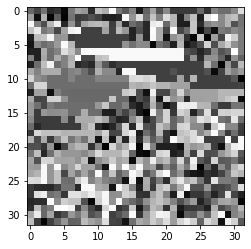

In [68]:
plt.imshow(sample[0, 0, ...].cpu().view(32, 32), cmap='gray')

In [69]:
quantized = vqvae.get_quantized(sample)
reconstructions = vqvae.decoder(quantized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


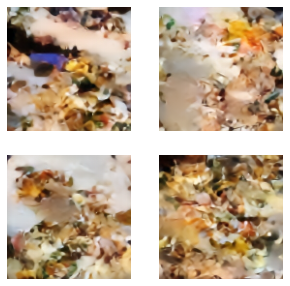

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

for i in range(4):
    ax[i // 2, i % 2].imshow(reconstructions[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[i // 2, i % 2].axis('off')
plt.show()